In [ ]:
#libraries needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
#csv file with data on electricity load and prices for all EU countries/regions per 60 min (for 2015 tunill 2020)
dfelect = pd.read_csv('downloads/time_series_60min_singleindex.csv')
#extracting the columns we need, 
dfnew = dfelect[['utc_timestamp','NO_1_price_day_ahead','IT_CNOR_price_day_ahead','BE_load_actual_entsoe_transparency']]
#converting to panda datetime object
dfnew['utc_timestamp'] = pd.to_datetime(dfnew['utc_timestamp'])
#setting the index
dfelectra = dfnew.set_index('utc_timestamp')


<bound method NDFrame._add_numeric_operations.<locals>.mean of utc_timestamp
2015-01-01 00:00:00+00:00    9484.0
2015-01-01 01:00:00+00:00    9152.0
2015-01-01 02:00:00+00:00    8799.0
2015-01-01 03:00:00+00:00    8567.0
2015-01-01 04:00:00+00:00    8487.0
                              ...  
2015-12-31 19:00:00+00:00    9010.0
2015-12-31 20:00:00+00:00    8787.0
2015-12-31 21:00:00+00:00    9137.0
2015-12-31 22:00:00+00:00    9321.0
2015-12-31 23:00:00+00:00    8825.0
Name: BE_load_actual_entsoe_transparency, Length: 8760, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.mean of utc_timestamp
2016-01-01 00:00:00+00:00     8348.0
2016-01-01 01:00:00+00:00     7910.0
2016-01-01 02:00:00+00:00     7614.0
2016-01-01 03:00:00+00:00     7476.0
2016-01-01 04:00:00+00:00     7503.0
                              ...   
2016-12-31 19:00:00+00:00    10209.0
2016-12-31 20:00:00+00:00     9937.0
2016-12-31 21:00:00+00:00    10185.0
2016-12-31 22:00:00+00:00    10393.0
2016-12-

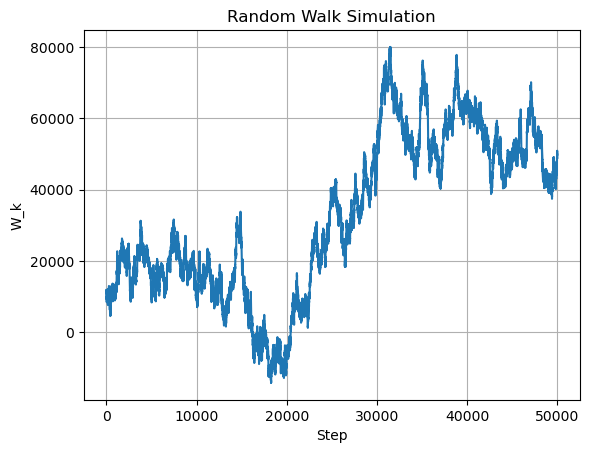

In [203]:
for x in range(2015,2021):
    #dataframe for just the year 
    data = dfelectra.loc[str(x)]
    #printing the mean load per year 
    print(data['BE_load_actual_entsoe_transparency'].mean)
#average drift over 6 years, calculated per year, done with the forloop above.
drift1 = (9076.49-10045.27)/6

#create two new columns that give for every oberservation the year and the month
dfelectra['month'] = dfelectra.index.month
dfelectra['year'] = dfelectra.index.year
#calculates for all oberservations over the 6 years the mean per month
monthly_avg_price = dfelectra.groupby('month')['BE_load_actual_entsoe_transparency'].mean()
month = monthly_avg_price
#for the second drift calculate the drift over the months (from month 1 till 12) 
drift2 = (monthly_avg_price - month.mean())

#this gives the differences for two consecutive observations, needed as we calculate differences for the update step
differences = dfelectra['BE_load_actual_entsoe_transparency'].diff().dropna()
#calculate the standard deviation for the difference of observations.
sigma = differences.std()


#take 2 we do a random walk with time/timestep amount of steps
#function that gives a drifted random gaussian walk based on the parameters from the data
def stochastic_differential(initialvalue,drift1,drift2,sigma,time,timestep):
    #steps is how often we to update the path
    steps = int(time/timestep)
    #this is a vector that makes evenly big numbers from 0 till time of specified steps 
    times = np.linspace(0, time, steps)
    #this vector is initizalid as zeros and will store all differences
    differencew = np.zeros(steps)
    #here the values of the random walk will be stored for every step 
    valuesw = np.zeros(steps)
    #the first value of this vector will be the initialvalue of the process, based on the data
    valuesw[0] = initialvalue
    #need the hours per year as the observations are in hours but one time unit here is a year
    hours_per_year = (24*364)
    #loop through all the steps
    for x in range(1,steps):
        #we set i to x, to calculate the monthly drift, as this has to start over every year
        i = x
        #we make sure that if we simulate more than 1 time unit (1year), that if we have simuluated more than one year we go back to month 1
        while i >= int(time/timestep)/time:
            #if more than one year has passed, recaculate i such that the month value always stays between 0 and 12 
            i = i - int(int(time/timestep)/time)
        #this calculates how far we are in a year 
        total_time_elapsed = i * timestep
        
        # Convert total time elapsed to months (approximation)
        month = int(total_time_elapsed * 12)+1
        
        ratio = np.sqrt(timestep * hours_per_year)
        adjusted_sigma = sigma*ratio
        differencew[x] = (drift2[month] + drift1)*timestep + adjusted_sigma*np.random.normal()
        valuesw[x] = valuesw[x-1]+ differencew[x]
    return valuesw
t = stochastic_differential(10943,drift1,drift2,sigma,5,0.0001)
plt.plot(t)
plt.title("Random Walk Simulation")
plt.xlabel("Step")
plt.ylabel("W_k")
plt.grid(True)
plt.show()
#for x in range(35,39):
    
#    t = stochastic_differential(10943,drift1,drift2,x,1,0.001)
#    print(x)
#    print(abs(t.var() - dfelectra['BE_load_actual_entsoe_transparency'].var()))


In [ ]:
x = 8000
timestep = 0.00001
total_time_elapsed = x * timestep
        
        # Convert total time elapsed to months (approximation)
print(int(total_time_elapsed * 12+1))

        # Determine the current month and adjust for cycling through months
#current_month = (start_month + total_months_elapsed - 1) % 12 + 1

In [ ]:
plt.plot(dfelectra.index, dfelectra['BE_load_actual_entsoe_transparency'], linewidth =0.5)

In [ ]:
def random_walk(delta_t, n):
    # Initialize the starting point
    W = np.zeros(n+1)  # W_0 = 0 and store 
    
    # Iterate over the steps
    for step in range(1, n+1):
        epsilon = np.random.choice([-1, 1], p = [0.5,0.5])  # Generate ε_k
        W[step] = W[step-1] + epsilon * np.sqrt(delta_t / n)  # Calculate W_k
    
    return W
def stock_price(initial_price, W,drift):
    S = np.zeros(n+2)
    S[0] = initial_price
    print(S)
    for step in range(1,n+1):
        S[step] = S[step-1]*(1+drift) + W[step] 
    print(S[n-200:n+2])
    return S
        
    

# Example of usage:
delta_t = 100
n = 10000  
walk = random_walk(delta_t, n)
stockprice = stock_price(100,walk,0.05)
plt.plot(stockprice)
plt.title("Random Walk Simulation")
plt.xlabel("Step")
plt.ylabel("W_k")
plt.grid(True)
plt.show()

In [ ]:
#take 2 we do a random walk with time/timestep amount of steps
def stochastic_differential(drift,sigma,time,timestep):
    #steps is how often we need to calculate the path
    steps = int(time/timestep)
    print(steps)
    #this is a vector that makes evenly big numbers from 0 till time of specified steps 
    times = np.linspace(0, time, steps)
    #this vector is initizalid as zeros and will store all differences
    differencew = np.zeros(steps)
    #here the values of the random walk will be stored for every step 
    valuesw = np.zeros(steps)
    for x in range(1,steps):
        differencew[x] = drift*timestep + (sigma**0.5)*np.random.normal()
        valuesw[x] = valuesw[x-1]+ differencew[x]
    return valuesw
t = stochastic_differential(100,10,10,0.001)
plt.plot(t)
plt.title("Random Walk Simulation")
plt.xlabel("Step")
plt.ylabel("W_k")
plt.grid(True)
plt.show()
